In [1]:
def load_pickle_data(file_path,has_control):
        '''load pickle data file for deep Koopman dynamic mode decomposition. 
        Args: 
           file_path: 

        '''     
        file_obj = file(file_path,'rb');
        output_vec = pickle.load(file_obj);

        Yp = output_vec[0]; # list of baseline observables, len(Yp) = (n_samps-1) 
        Yf = output_vec[1]; # list of baseline observables, len(Yf) = (n_samps-1) 

        print "DEBUG:" + repr(len(output_vec));
        if has_control:
          u_control_all_training = output_vec[2];
          #print u_control_all_training[0:10]
        else:
          u_control_all_training = None;
          
        if len(Yp)<2:
            print "Warning: the time-series data provided has no more than 2 points."
    
        Y_whole = [None]*(len(Yp)+1);
        
        for i in range(0,len(Yp)+1):
            if i == len(Yp):
                Y_whole[i] = Yf[i-1];
            else:
                Y_whole[i] = Yp[i];

        Y_whole = np.asarray(Y_whole);
        
        return np.asarray(Yp),np.asarray(Yf),Y_whole,u_control_all_training;
        
     

In [2]:
#! /usr/bin/env python
with_control = 1;
import pickle;
import numpy as np;
from numpy.linalg import pinv;
from numpy.polynomial.legendre import legvander;
import cvxopt;
from cvxpy import Minimize, Problem, Variable,norm1,norm2,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy;
import tensorflow as tf

def quad_form(X,vec):
    temp = np.dot(X,vec);
    return np.dot(vec.T,temp)[0][0];

sess = tf.InteractiveSession();
#tf.reset_default_graph()

sess = tf.InteractiveSession();
saver = tf.train.import_meta_graph('/Users/yeun026/Documents/darpa-sd2/deepDMD/MD.pickle.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('/Users/yeun026/Documents/darpa-sd2/deepDMD/'));


yp_feed = tf.get_collection('yp_feed')[0];
yf_feed = tf.get_collection('yf_feed')[0];


Kx = tf.get_collection('Kx')[0];


Kx_num = sess.run(Kx);

A = np.transpose(Kx_num); # Kx_num and Ku_num were defined using row multi. 

psiyp = tf.get_collection('psiyp')[0];
psiyf = tf.get_collection('psiyf')[0];
if with_control:
    forward_prediction_control = tf.get_collection('forward_prediction_control')[0];
    psiu = tf.get_collection('psiu')[0];
    u_control = tf.get_collection('u_control')[0];
    #Ku = tf.get_collection('Ku')[0];
    #Ku_num = sess.run(Ku);
    #B = np.transpose(Ku_num);
    #print B;
    #D = np.zeros((A.shape[0],B.shape[1]));
else:
    forward_prediction = tf.get_collection('forward_prediction')[0];

C = np.eye(Kx_num.shape[0]); # assume full state measurements




In [3]:

data_directory = '/Users/yeun026/Documents/darpa-sd2/deepDMD/koopman_data/'
data_suffix = 'MD.pickle';
data_file = data_directory + data_suffix;

if with_control:
    Yp,Yf,Y_whole,u_control_all_training = load_pickle_data(data_file,with_control)
    u_control_all_training_old = u_control_all_training   
else:
    Yp,Yf,Y_whole,temp_var = load_pickle_data(data_file,with_control);

print "[INFO] Number of total samples: " + repr(len(Yp));
print "[INFO] Observable dimension of a sample: " + repr(len(Yp[0]));
num_bas_obs = len(Yp[0]);
num_all_samples = len(Yp);


DEBUG:3
[INFO] Number of total samples: 20000
[INFO] Observable dimension of a sample: 10


In [8]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)



0
[RESULT] n-step Prediction error: 0.117102
1
[RESULT] n-step Prediction error: 0.163965
2
[RESULT] n-step Prediction error: 0.049609
3
[RESULT] n-step Prediction error: 0.109123
4
[RESULT] n-step Prediction error: 0.292827
5
[RESULT] n-step Prediction error: 0.200496
6
[RESULT] n-step Prediction error: 0.101966
7
[RESULT] n-step Prediction error: 0.023366
8
[RESULT] n-step Prediction error: 0.082575
9
[RESULT] n-step Prediction error: 0.135455
10
[RESULT] n-step Prediction error: 0.148460
11
[RESULT] n-step Prediction error: 0.081906
12
[RESULT] n-step Prediction error: 0.304559
13
[RESULT] n-step Prediction error: 0.386498
14
[RESULT] n-step Prediction error: 0.136996
15
[RESULT] n-step Prediction error: 0.065206
16
[RESULT] n-step Prediction error: 0.156080
17
[RESULT] n-step Prediction error: 0.056510
18
[RESULT] n-step Prediction error: 0.117060
19
[RESULT] n-step Prediction error: 0.175288
20
[RESULT] n-step Prediction error: 0.186793
21
[RESULT] n-step Prediction error: 0.08824

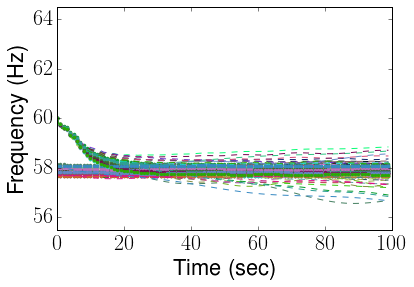

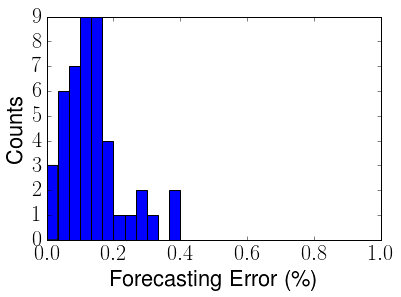

In [13]:
pred_list = [];
colors = np.random.rand(10,3)
n_points_pred = 100;
#train_max = n_points_pred*(well_ind);  
for well_ind in range(0,45):
    print well_ind
    
    start_ind = well_ind*(n_points_pred); 
    end_ind = (well_ind+1)*(n_points_pred); 
    this_data = Yp[start_ind:end_ind];
    this_control_data = u_control_all_training_old[start_ind:end_ind]
    num_bas_obs = len(this_data[0]);
    debug_splash = 0;


    n_points_sim = 99;
    ### Load Training and Test Data (Ground Truth)  ###
    U_test = this_control_data[1:]; 
    U_test = np.asarray(U_test); 
    n_inputs_control = U_test.shape[1];
    Yf_final_test = this_data[1:];
    Yf_final_test = np.asarray(Yf_final_test).T; 

    Ycurr = this_data[0];
    Ycurr = np.asarray(Ycurr).T; 
    Ycurr = Ycurr.reshape(1,num_bas_obs);

    import matplotlib.pyplot as plt 

    # # # - - - n-step Prediction Error Analysis - - - # # # 

    psiyp_Ycurr = psiyp.eval(feed_dict={yp_feed:Ycurr});
    psiyf_Ycurr = psiyf.eval(feed_dict={yf_feed:Ycurr});

    ### DEBUG ###
    if debug_splash:
        print "[DEBUG] Ycurr.shape: " + repr(Ycurr.shape);
        print "[DEBUG]: " + repr(psiyp_Ycurr.shape)
        print "[DEBUG] U_test.shape" + repr(U_test.shape);

    Yf_final_test_ep_nn = [];
    Yf_final_test_ep_nn.append(psiyp_Ycurr.tolist()[0][0:num_bas_obs]); # append the initial seed state value.

    ### Construct Neural Network Based Predictions (n_points_sim into the future) ### 

    for i in range(0,n_points_sim):
        if with_control:
            #print U_test.shape
            if len(U_test[i,:])==1:
                U_temp_mat = np.reshape(U_test[i,:],(1,1));
                psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});#
            else:
                U_temp_mat = np.reshape(U_test[i,:],(1,n_inputs_control));
                psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});# 
        else:
            psiyp_Ycurr = sess.run(forward_prediction,feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs]});

        Yout = psiyp_Ycurr.tolist()[0][0:num_bas_obs];
        Yf_final_test_ep_nn.append(Yout);

    Yf_final_test_ep_nn = np.asarray(Yf_final_test_ep_nn);
    Yf_final_test_ep_nn = np.transpose(Yf_final_test_ep_nn);

    ### End Construct Neural Network Based Predictions (n_points_sim into the future) ### 

    if debug_splash:
        print "[DEBUG] Yf_final_test_ep_nn.shape: " + repr(Yf_final_test_ep_nn.shape);

    ### Construct a ground truth matrix ### 
    Yf_final_test_stack_nn = np.asarray(this_data[0:n_points_pred]).T; 
    # DEBUG Statements 

    if debug_splash:
        #print "[DEBUG] Yf_final_test_stack_nn: " +repr(Yf_final_test_stack_nn);
        #print "[DEBUG] Yf_final_test_ep_nn:" +  repr(Yf_final_test_ep_nn);
        #print "[DEBUG] Yf_final_test_stack_nn - Yf_final_test_ep_nn : " + repr(Yf_final_test_stack_nn - Yf_final_test_ep_nn);
        #print "[DEBUG] Y_final_test_stack.shape: " + repr(Yf_final_test_stack_nn.shape);
        print "[INFO] Ground truth Yf_final_test_ep_stack.shape: "+ repr( Yf_final_test_stack_nn.shape);
        print "[INFO] Prediction Yf_final_test_ep_nn.shape: "+ repr(Yf_final_test_ep_nn.shape);
        #print "Denominator of prediction error: " + repr(np.linalg.norm(Yf_final_test_stack_nn,ord='fro'));

    ### 
    #Yf_final_test_stack_nn = y_scaler.inverse_transform(Yf_final_test_stack_nn.T).T
    #Yf_final_test_ep_nn = y_scaler.inverse_transform(Yf_final_test_ep_nn.T).T


    prediction_error = np.linalg.norm(Yf_final_test_stack_nn-Yf_final_test_ep_nn,ord='fro')/np.linalg.norm(Yf_final_test_stack_nn,ord='fro');
    print('%s%f' % ('[RESULT] n-step Prediction error: ',prediction_error));
    pred_list.append(prediction_error);
    
    x_range = np.arange(0,Yf_final_test_stack_nn.shape[1],1);
    
    if prediction_error < 10:
        for j in range(0,1):
            temp_color = np.random.rand(3,1);
            plt.plot(x_range,60.0+Yf_final_test_ep_nn[j,:],'--',color=temp_color);
            plt.plot(x_range,60.0+Yf_final_test_stack_nn[j,:],'.',color=temp_color);

            
#            plt.plot(x_range,Yf_final_test_ep_nn[i,:],'--',color=colors[i,:]);
#            plt.plot(x_range,Yf_final_test_stack_nn[i,:],'.',color=colors[i,:]);
        axes = plt.gca();
        plt.legend(loc='best');
        plt.xlabel('Time (sec)');
        plt.ylabel("Frequency (Hz)");
        plt.ylim([60.0-4.5,60.0+4.5])
        fig = plt.gcf();

        
       
plt.figure()
plt.hist(pred_list,bins=30,range=[0,1]);
plt.xlabel('Forecasting Error (\%)')
plt.ylabel('Counts')
plt.show()



In [6]:
Yf_final_test_stack_nn.shape

(10, 100)